# Using KGFE to understand important features

Basically, given a list of genes/proteins/metabolites that are mapped onto SPOKE, we want to identify nodes on the graph that are in some way "similar" to the input nodes.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load genes

In [2]:
data = pd.read_excel('LC_Male_proteins_for_KG.xlsx')

In [3]:
data.head()

,UniProt,ProteinName
0,P08697,A2AP
1,Q15848,ADIPO
2,P02760,AMBP
3,P15144,AMPN
4,P01019,ANGT


In [18]:
data.shape

(46, 2)

## 2. Load SPOKE

In [6]:
spoke_graph = kgfe.spoke_loader.load_spoke_networkx('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [8]:
# undirected version of spoke graph
spoke_graph_ud = nx.Graph(spoke_graph)

In [28]:
spoke_ids = list(sorted(spoke_graph_ud.nodes.keys()))

In [9]:
# find all connected nodes from the t2d node, and extract that subgraph
t2d_paths = nx.single_source_dijkstra(spoke_graph_ud, 2171832)
spoke_t2d_subgraph = nx.subgraph(spoke_graph, t2d_paths[0].keys())

In [10]:
len(spoke_t2d_subgraph)

619452

In [11]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Map proteins to SPOKE nodes

In [17]:
prot_spoke_ids = [names_to_ids[p + '_HUMAN'] for p in data.ProteinName]

## 3. Run topic PageRank

In [24]:
pr_results_personalized = nx.pagerank(spoke_graph_ud, personalization={i: 1 for i in prot_spoke_ids})

In [25]:
pr_results_base = nx.pagerank(spoke_graph_ud)

pr_results_ratio is the ratio between the topic pagerank results and the baseline pagerank results - this indicates the increase in likelihood that the nodes will be visited in a personalized random walk, and is an attempt to control for nodes that are important globally.

In [39]:
pr_results_ratio = {x: pr_results_personalized[x]/pr_results_base[x] for x in spoke_ids}

### Analyzing PageRank results

In [40]:
from collections import Counter

In [41]:
pr_results_personalized = Counter(pr_results_personalized)
pr_results_base = Counter(pr_results_base)
pr_results_ratio = Counter(pr_results_ratio)

In [57]:
top_nodes = []
prot_spoke_ids_set = set(prot_spoke_ids)
for node_id, score in pr_results_personalized.most_common():
    if node_id in prot_spoke_ids_set:
        continue
    node = spoke_graph_ud.nodes[node_id].copy()
    node['score'] = score
    top_nodes.append(node)

In [60]:
top_nodes_ratio = []
prot_spoke_ids_set = set(prot_spoke_ids)
for node_id, score in pr_results_ratio.most_common():
    if node_id in prot_spoke_ids_set:
        continue
    node = spoke_graph_ud.nodes[node_id].copy()
    node['score'] = score
    top_nodes_ratio.append(node)

In [63]:
top_nodes[:50]

[{'name': 'Class I Histocompatibility antigen, domains alpha 1 and 2',
  'type': 'ProteinDomain',
  'score': 0.014052099904896458},
 {'name': 'Immunoglobulin V-set domain',
  'type': 'ProteinDomain',
  'score': 0.009593095787071584},
 {'name': 'Immunoglobulin C1-set domain',
  'type': 'ProteinDomain',
  'score': 0.007333218380874164},
 {'name': 'Class II histocompatibility antigen, beta domain',
  'type': 'ProteinDomain',
  'score': 0.006994964128005253},
 {'name': 'PAN domain',
  'type': 'ProteinDomain',
  'score': 0.003838088304892079},
 {'name': 'Q5JVE7_HUMAN', 'type': 'Protein', 'score': 0.003526009688446931},
 {'name': 'Serpin (serine protease inhibitor)',
  'type': 'ProteinDomain',
  'score': 0.0024583139713069183},
 {'name': 'MHC_I C-terminus',
  'type': 'ProteinDomain',
  'score': 0.0023184693994324134},
 {'name': 'MTP_HUMAN', 'type': 'Protein', 'score': 0.00200710355108015},
 {'name': 'KCNH2_HUMAN', 'type': 'Protein', 'score': 0.0015809609869887552},
 {'name': 'A0A090N8Q0_HUMA

In [72]:
top_proteins = [x for x in top_nodes if x['type'] == 'Protein']
top_genes = [x for x in top_nodes if x['type'] == 'Gene']

In [64]:
top_nodes_ratio[:50]

[{'name': 'SERPING1', 'type': 'Gene', 'score': 356.7343204826498},
 {'name': 'ZBTB42', 'type': 'Gene', 'score': 233.5445499332574},
 {'name': 'PAN domain', 'type': 'ProteinDomain', 'score': 223.2769966297023},
 {'name': 'ZG16B_HUMAN', 'type': 'Protein', 'score': 201.00653297752825},
 {'name': 'ASPIC and UnbV',
  'type': 'ProteinDomain',
  'score': 191.94419487348162},
 {'name': 'B7Z3P3_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'C9J075_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'C9JCT1_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'C9JDP4_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'C9JS80_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'D6RB32_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'F8WCD6_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'H0Y596_HUMAN', 'type': 'Protein', 'score': 180.46124364223613},
 {'name': 'Q53QL7_HUMAN', 'ty

### Plot PageRank results

In [ ]:
import matplotlib.pyplot as plt

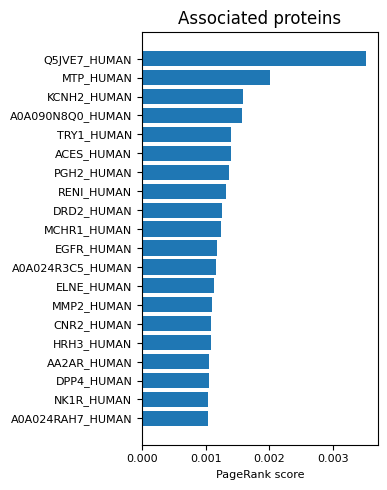

In [71]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in top_proteins[:20][::-1]], [x['score'] for x in top_proteins[:20][::-1]], )
plt.title('Associated proteins')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

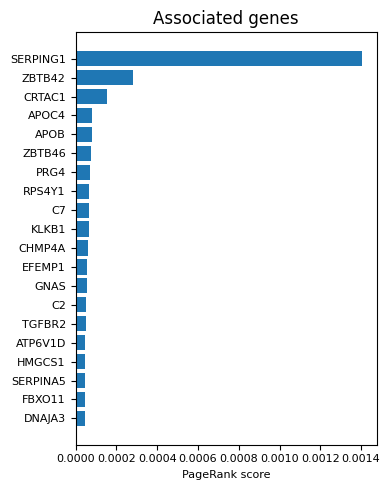

In [73]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in top_genes[:20][::-1]], [x['score'] for x in top_genes[:20][::-1]], )
plt.title('Associated genes')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

## 4. Construct Steiner trees for the gene query set

In order to do Steiner trees, it's necessary to get a connected graph. We'll try to build a connected graph that includes all the proteins in the query set.

In [74]:
protein_paths = nx.single_source_dijkstra(spoke_graph_ud, prot_spoke_ids[0])
protein_subgraph = nx.subgraph(spoke_graph, t2d_paths[0].keys())

In [75]:
protein_subgraph_ud = nx.Graph(protein_subgraph)

In [76]:
top_protein_st = nx.approximation.steiner_tree(protein_subgraph_ud, prot_spoke_ids, method='mehlhorn')

This is an approximate Steiner tree containing all of the input proteins.

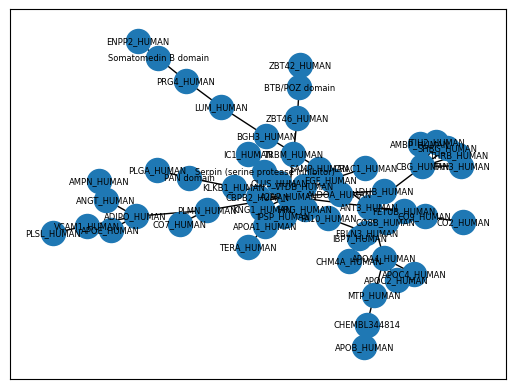

In [78]:
nx.draw_networkx(top_protein_st, pos=nx.spring_layout(top_protein_st),
                 labels={n: top_protein_st.nodes[n]['name'] for n in top_protein_st.nodes()}, font_size=6)

In [79]:
is_in_set = {n: n in prot_spoke_ids for n in top_protein_st.nodes}
nx.set_node_attributes(top_protein_st, is_in_set, 'in_query')

In [80]:
top_protein_subgraph = nx.subgraph(protein_subgraph, top_protein_st)

This is a directed subgraph containing the above Steiner tree (approximately the smallest subgraph containing all of the input proteins).

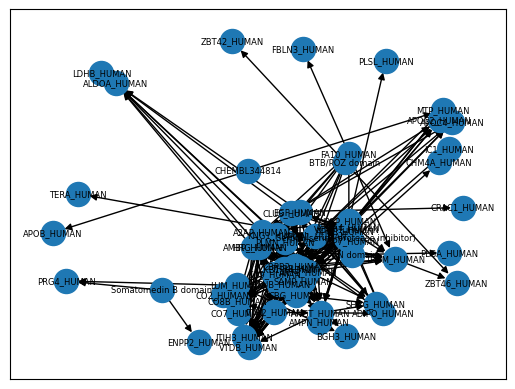

In [81]:
nx.draw_networkx(top_protein_subgraph, pos=nx.spring_layout(top_protein_subgraph),
                 labels={n: top_protein_subgraph.nodes[n]['name'] for n in top_protein_subgraph.nodes()}, font_size=6)